This notebook illustrates the main features of the Community Simulator package. 

# The Model

The Community Simulator is an open-ended platform, which can incorporate any ODE model based on concentrations of consumers and resources. The module comes with a built-in script for constructing variants of the MacArthur Consumer Resource Model (CRM), allowing for crossfeeding, metabolic regulation, and type I, II and III response functions. The full description of the range of modeling capabilities will be described in the documentation accompanying a future release. In this notebook, we will focus on the MacArthur CRM with type I response and independent metabolic fluxes. At the end, we will also briefly introduce the crossfeeding term.

In the MacArthur CRM with resource regeneration turned off (in order to model batch culture), the populations $N_i$ of $S$ distinct species and the concentrations $R_\alpha$ of $M$ distinct resources evolve according to the following ODE's:

\begin{align}
\frac{dN_i}{dt} &= N_i g_i\left[ \sum_\beta c_{i\beta}w_\beta R_\beta - m_i\right]\\
\frac{dR_\alpha}{dt} &= - R_\alpha\sum_j c_{j\alpha}N_j.
\end{align}

For now, we will measure resource concentrations in units of biomass equivalent, so that $w_\alpha = 1$. The remaining parameters $c_{i\alpha}$ and $m_i$ will be explained in the following sections.

The functions `MakeResourceDynamics` and `MakeConsumerDynamics` in the `usertools` submodule construct the right-hand sides of these equations as functions of the $N_i$ and $R_\alpha$ vectors. The keyword arguments specify the modeling assumptions concerning response type, regulation, and replenishment of resources:

In [1]:
from community_simulator.usertools import MakeConsumerDynamics,MakeResourceDynamics

assumptions = {'response':'type I','regulation':'independent','replenishment':'off'}

def dNdt(N,R,params):
    return MakeConsumerDynamics(**assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(**assumptions)(N,R,params)

Defining these functions at the top level of your code allows them to be pickled and sent to multiple CPU's during built-in parallel execution.

## Load parameters from Excel

Community Simulator is designed to work with Pandas, a powerful data science module that comes pre-installed with the Anaconda Python distribution. We can use Pandas to load in the parameters for our simulation from a Microsoft Excel spreadsheet. 

The Pandas syntax is very straightforward: you just feed the `read_excel` function the filename of the spreadsheet, and (if there are multiple sheets in the workbook) the name of the sheet you want to load. The workbook `test_data.xlsx` included with this distribution contains six sheets, with all the information required to run a simple experiment.

## Consumption Matrix

Let's start by loading the consumption matrix $c_{i\alpha}$, which is the heart of the MacArthur Consumer Resource Model (CRM) and all its variants:

In [5]:
import pandas as pd
c = pd.read_excel('data/test_data.xlsx',sheet_name='Consumption')
c

,Glutamine,Citrate,R2,R3,R4,R5,R6,R7,R8
Enterobacter,1.000,0.001,0.01,0.01,0.01,0.01,0.01,0.01,0.01
Pseudomonas,0.001,0.990,0.01,0.01,0.01,0.01,0.01,0.01,0.01
Flavobacter,0.480,0.490,0.01,0.01,0.01,0.01,0.01,0.01,0.01
Enterococca,0.490,0.480,0.01,0.01,0.01,0.01,0.01,0.01,0.01


This matrix specifies the per capita consumption rate of each nutrient for each species. The vector of consumption rates is what defines a species for the purposes of the model. I have given the two primary carbon sources realistic names, and also supplied a low level of six "unknown" resources. (Note: These are not meant to be the actual consumption vectors for the four bacterial strains listed here; the only purpose of the names is to make clear that each row represents a distinct strain.)

## Cost Vector

The MacArthur CRM contains another important set of parameters, which are the minimal consumption rates $m_i$ required for survival. For this example, we will set all of them to be equal:

In [3]:
import pandas as pd
m = pd.read_excel('data/test_data.xlsx',sheet_name='Cost')
m

,Cost
Enterobacter,0.001
Pseudomonas,0.001
Flavobacter,0.001
Enterococca,0.001


## Initial Conditions

Now let's set the initial cell densities $N_i(0)$ in each wells of our example four-well plate:

In [4]:
N0 = pd.read_excel('data/test_data.xlsx',sheet_name='Populations')
N0

,well1,well2,well3,well4
Enterobacter,1,0,1,0
Pseudomonas,1,0,0,0
Flavobacter,0,1,0,0
Enterococca,0,1,0,0


When we perform serial dilution experiments later on, the absolute numbers of individuals will be important. By default, the density is measured in units of $10^9$ cells/well. 

Another sheet lists the initial concentrations of nutrients $R_\alpha(0)$ in each well:

In [5]:
R0 = pd.read_excel('data/test_data.xlsx',sheet_name='Resources')
R0

,well1,well2,well3,well4
Glutamine,1.0000,1.0000,1.0000,1.0000
Citrate,1.0000,1.0000,1.0000,1.0000
R2,0.0001,0.0001,0.0001,0.0001
R3,0.0001,0.0001,0.0001,0.0001
R4,0.0001,0.0001,0.0001,0.0001
R5,0.0001,0.0001,0.0001,0.0001
R6,0.0001,0.0001,0.0001,0.0001
R7,0.0001,0.0001,0.0001,0.0001
R8,0.0001,0.0001,0.0001,0.0001


These concentrations will be supplied to these wells every time we passage the cells. 

## Protocol

The feature that really makes this Community Simulator package unique is the built-in passaging functionality. The Passage method takes as an argument a matrix $f$ like this one:

In [7]:
f_dilute = pd.read_excel('data/test_data.xlsx',sheet_name='Dilute')
f_dilute

,well1,well2,well3,well4
well1 new,0.001,0.000,0.000,0.000
well2 new,0.000,0.001,0.000,0.000
well3 new,0.000,0.000,0.001,0.000
well4 new,0.000,0.000,0.000,0.001


The matrix specifies what fraction of each well should be loaded into each of the fresh wells. This is where the absolute number of cells in each well becomes important, because the program always loads an integer number of cells of each species into the new wells, choosing these numbers by multinomial sampling.

This particular matrix is a simple dilution protocol, taking 0.1% of each well and loading it into the corresponding well on the new plate. But we can also make more complicated protocols, like this one for simulating two-dimensional spatial structure:

In [10]:
L = 10 #Number of demes per axis
k = 0.2 #Fraction of deme to transfer to each neighbor
vert = np.ones(L**2-1)
for m in range(1,L):
    vert[L*m-1] = 0
horz = np.ones(L**2-L)
f_space = k*(np.diag(vert,-1)+np.diag(horz,-L))
f_space = f_space+f_space.T
f_space = f_space + np.eye(L**2)*(1-f_space.sum(axis=1))

In [11]:
f_space_vis = pd.DataFrame(f_space[:4,:4],columns=f_dilute.keys())
f_space_vis.index = f_dilute.index
f_space_vis

,well1,well2,well3,well4
well1 new,0.6,0.2,0.0,0.0
well2 new,0.2,0.4,0.2,0.0
well3 new,0.0,0.2,0.4,0.2
well4 new,0.0,0.0,0.2,0.4


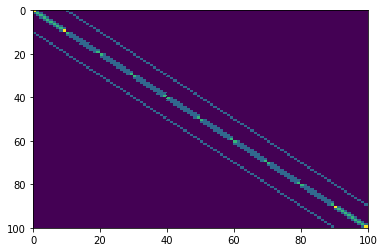

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.pcolor(f_space)
plt.gca().invert_yaxis()
plt.show()

This matrix transfers a fixed fraction of each well to its four closest neighbors (north, south, east, west), simulating diffusion in a two-dimensional environment.

# The Community Class

With all these variables loaded, we can now create an instance of the "Community" class. This instance will contain the current population levels and resource concentrations in each well, and also holds the equations and the parameters that define the model. 

In [19]:
from community_simulator import Community
import numpy as np
from community_simulator.usertools import MakeConsumerDynamics,MakeResourceDynamics
import pandas as pd

init_state = [pd.read_excel('data/test_data.xlsx',sheet_name='Populations'),
              pd.read_excel('data/test_data.xlsx',sheet_name='Resources')]

assumptions = {'regulation':'independent','replenishment':'off','response':'type I'}
def dNdt(N,R,params):
    return MakeConsumerDynamics(**assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(**assumptions)(N,R,params)
dynamics = [dNdt,dRdt]

params={'c':pd.read_excel('data/test_data.xlsx',sheet_name='Consumption'),
        'm':pd.read_excel('data/test_data.xlsx',sheet_name='Cost'),
        'w':np.ones(len(init_state[1])),
        'g':np.ones(len(init_state[0]))
       }


MyPlate = Community(init_state,dynamics,params,scale=10**9)

"Community" takes three mandatory arguments for initialization: the initial state, the dynamics, and the parameters. There is also an option for adjusting the units of $N_i$, which are set by default to $10^9$/well.

We can test whether things are working by following the population of a single well over time:

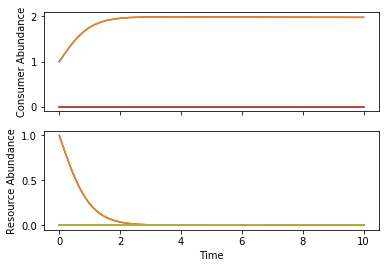

In [20]:
t, Ntraj, Rtraj = MyPlate.TestWell(T=10)

The basic methods of the `Community` class are `Propagate`, which simply runs the model for a fixed amount of time, and `Passage`, which passages the cells to a fresh plate following the protocol matrix $f$ that is passed as an argument.

In [21]:
f_dilute = pd.read_excel('data/test_data.xlsx',sheet_name='Dilute')
MyPlate.Passage(f_dilute)
MyPlate.N

,well1,well2,well3,well4
Enterobacter,0.001,0.000000,0.001,0.0
Pseudomonas,0.001,0.000000,0.000,0.0
Flavobacter,0.000,0.001001,0.000,0.0
Enterococca,0.000,0.000999,0.000,0.0


We can automatically run $n$ serial dilutions using protocol $f$ at fixed time intervals $T$ using the `RunExperiment` method:

In [22]:
n = 10
T = 10
Ntraj,Rtraj=MyPlate.RunExperiment(f_dilute,T,n)
MyPlate.N

,well1,well2,well3,well4
Enterobacter,0.954877,0.000000,0.958298,0.0
Pseudomonas,0.950349,0.000000,0.000000,0.0
Flavobacter,0.000000,0.931668,0.000000,0.0
Enterococca,0.000000,0.947309,0.000000,0.0


Note that `RunExperiment` returns trajectory outputs `Ntraj` and `Rtraj`, which are multiindex dataframes:

In [23]:
Ntraj

Enterobacter  Pseudomonas  Flavobacter  Enterococca
Time Well                                                      
0    well1      0.001000     0.001000     0.000000     0.000000
     well2      0.000000     0.000000     0.001001     0.000999
     well3      0.001000     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
10   well1      0.054806     0.050786     0.000000     0.000000
     well2      0.000000     0.000000     0.040755     0.041829
     well3      0.055430     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
20   well1      0.572558     0.527507     0.000000     0.000000
     well2      0.000000     0.000000     0.422748     0.428738
     well3      0.575601     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
30   well1      0.929275     0.916554     0.000000     0.000000
     well2      0.000000     0.000000     0.871818     0.886877
     well3      0.932368     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
40   well1      0.953869     0.948641     0.000000     0.000000
     well2      0.000000     0.000000     0.927747     0.943929
     well3      0.957160     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
50   well1      0.954841     0.950264     0.000000     0.000000
     well2      0.000000     0.000000     0.930190     0.948369
     well3      0.958250     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
60   well1      0.954931     0.950284     0.000000     0.000000
     well2      0.000000     0.000000     0.930216     0.948736
     well3      0.958296     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
70   well1      0.954940     0.950278     0.000000     0.000000
     well2      0.000000     0.000000     0.931194     0.947782
     well3      0.958298     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
80   well1      0.954877     0.950349     0.000000     0.000000
     well2      0.000000     0.000000     0.930550     0.948426
     well3      0.958298     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
90   well1      0.954896     0.950329     0.000000     0.000000
     well2      0.000000     0.000000     0.931186     0.947791
     well3      0.958298     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
100  well1      0.954877     0.950349     0.000000     0.000000
     well2      0.000000     0.000000     0.931668     0.947309
     well3      0.958298     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000

# Run a little experiment

Now let's run an experiment to explore the emergence of effective higher-order interactions in a serial dilution experiment. We will compete the Enterobacter from Well 1 against the two species of Well 2, with and without the Pseudomonas from Well 1. We implement this with another protocol included on the `test_data` spreadsheet:

In [24]:
f_mix = pd.read_excel('data/test_data.xlsx',sheet_name='Mix')
f_mix

,well1,well2,well3,well4
well1 new,0.001,0.000,0.000,0
well2 new,0.000,0.001,0.000,0
well3 new,0.001,0.001,0.000,0
well4 new,0.000,0.001,0.001,0


This protocol uses Well 3 to mix the contents of Well 1 with those of Well 2, while Well 4 mixes the previous contents of Well 3 (which was just the Enterobacter) with Well 2. The original contents of Well 1 and Well 2 are preserved in the same wells.

In [25]:
f_mix = pd.read_excel('data/test_data.xlsx',sheet_name='Mix')
MyPlate.Passage(f_mix)
MyPlate.Propagate(T)
Ntraj,Rtraj=MyPlate.RunExperiment(f_dilute,T,n)

We can plot the trajectory using `PlotTraj` from the `visualization` submodule as `PlotTraj(Ntraj)`:

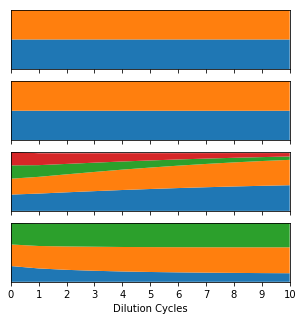

In [26]:
from community_simulator.visualization import PlotTraj
import matplotlib.pyplot as plt
%matplotlib inline
PlotTraj(Ntraj,figsize=(5,5))
plt.show()

The four panels represent the four wells. Each color is a species, and the thickness of the colored bar at each dilution cycle is proportional to the population of that species at the end of that cycle. 

The first two panels are controls, which simply propagate the two initial communities (which I will call 'A' and 'B'). The third panel shows the result of invading B with all of A, as can be seen by the presence of all four colors. The fourth is the invasion by the Enterobacter alone.

We can also visualize the final result in a bar plot with a legend, which may be easier to read:

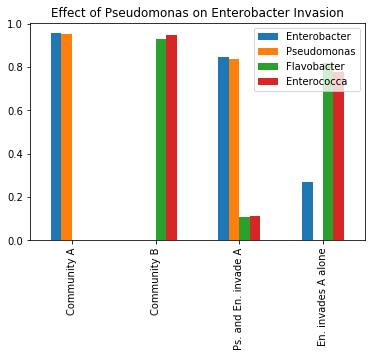

In [27]:
from community_simulator.visualization import StackPlot
import matplotlib.pyplot as plt
%matplotlib inline
MyPlate.N.T.plot.bar()
plt.gca().set_title('Effect of Pseudomonas on Enterobacter Invasion')
plt.gca().set_xticklabels(['Community A','Community B','Ps. and En. invade A','En. invades A alone'])
plt.show()

In this example, Enterobacter does better when invading together with Pseudomonas than it does alone. I contrived the example to have this result, by making the two species of Community A almost perfect specialists, and those of B almost perfect generalists. 

# Crossfeeding

The above examples were all run in the original MacArthur Consumer Resource Model, without crossfeeding. But the most interesting model predictions come from the addition of crossfeeding. As discussed in detail in Marsland \emph{et al.} arXiv 1805.12516 (2018), we assume that a fraction $e_\beta$ ($= 1- l_\beta$ in the notation of the paper) of the energy contained in the incoming flux of resource $\beta$ is used for growth, and the rest of the energy is released into the environment in the form of secreted byproducts (and heat). We define a metabolic matrix $D_{\alpha \beta}$ that determines how this outgoing flux is partitioned among the various byproducts, to arrive at the following equations:

\begin{align}
\frac{dN_i}{dt} &= N_i g_i \left[ \sum_\beta e_\beta w_\beta c_{i\beta} R_\beta - m_i\right]\\
\frac{dR_\alpha}{dt} &=  - R_\alpha \sum_j c_{j\alpha}N_j +\sum_{\beta, j} (1-e_\beta) \frac{w_\beta}{w_\alpha}D_{\alpha \beta}c_{j\beta}N_j R_\beta.
\end{align}

The `usertools` submodule contains a function for generating random $c_{i\alpha}$ and $D_{\alpha\beta}$ matrices, with the sampling performed in such a way that members of different families of consumers can prefer different types of resources. The sampling protocols are fully described in the Appendix to Marsland \emph{et al.}, cited above. The code snippet below describes all the parameters required to construct the matrices. In addition to these parameters, you can also choose whether to sample the $c$ matrix from a Gaussian, a Gamma or a Binary distribution.

In [63]:
from community_simulator.usertools import MakeMatrices

metaparams = {'SA': 10*np.ones(4), #Number of species in each family
          'MA': 25*np.ones(4), #Number of resources of each type
          'Sgen': 10, #Number of generalist species
          'muc': 10, #Mean sum of consumption rates in Gaussian model
          'sigc': .01, #Variance in consumption rate in Gaussian model
          'q': 0.5, #Preference strength (0 for generalist and 1 for specialist)
          'c0':0.01, #Background consumption rate in binary model
          'c1':1., #Maximum consumption rate in binary model
          'fs':0.3, #Fraction of secretion flux with same resource type
          'fw':0.6, #Fraction of secretion flux to 'waste' resource
          'D_diversity':0.05 #Variability in secretion fluxes among resources (must be less than 1)
         }
c, D = MakeMatrices(kind='Binary',metaparams=metaparams)

The consumers defined by this $c_{i\alpha}$ matrix come in four families, labeled F0, F1 and F2 and GEN. The resources come in three types, T0, T1 and T2. Each family contains twenty consumer species, and each type contains twenty-five resource species. Each of the first three families prefers a particular type of resources (F0 prefers T0, etc.), while the generalists GEN have equal preference across all types.

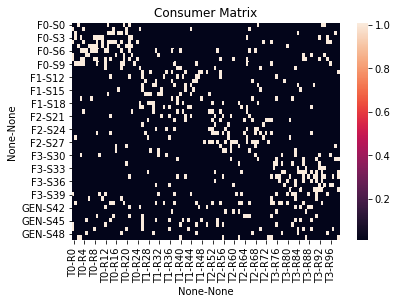

In [64]:
import seaborn as sns
sns.heatmap(c)
plt.gca().set_title('Consumer Matrix')
plt.show()

The $D_{\alpha\beta}$ matrix is structured to reflect the rough features of biochemistry: a fraction $f_w$ of byproducts secreted from any metabolic channel are 'waste' molecules (carboxylic acids). Most of the remaining secretion, occupying a fraction $f_s$ of the total, is of the same type as the source molecule: modified sugars are lost during sugar metabolism, amino acids are lost during amino acid metabolism, etc. We partition the rest of the secretion randomly among all molecular species. In the following example, T0 contains the carboxylic acids.

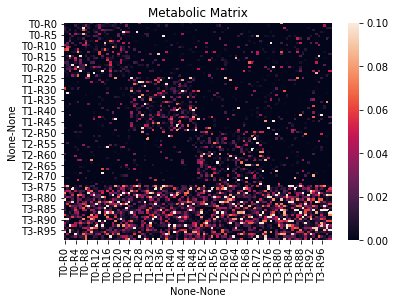

In [70]:
sns.heatmap(D,vmax=0.1)
plt.gca().set_title('Metabolic Matrix')
plt.show()

Note that none of the input parameters have to be dataframes, but it's convenient to use them for pedagogical purposes. Let's simulate batch culture of this community in 5 wells. We will supply 10 units of resource R8 in each fresh well, but none of the other resources.

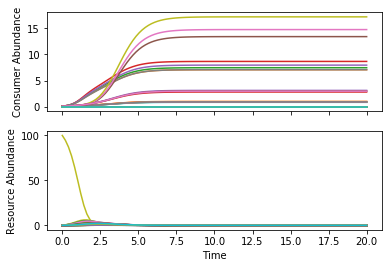

In [60]:
from community_simulator.usertools import BinaryRandomMatrix
from community_simulator import Community
import numpy as np
from community_simulator.usertools import MakeConsumerDynamics,MakeResourceDynamics,AddLabels
import pandas as pd

#Set experiment parameters
S_tot = len(c)
S_well = 20
n_wells = 5
M = len(D)

#Compute probability of finding a given species in a given well
p = S_well*1./S_tot

#Create initial conditions
N0 = BinaryRandomMatrix(S_tot,n_wells,p)*0.1
R0 = np.zeros((M,n_wells))
R0[8] = 5*S_well
N0,R0 = AddLabels(N0,R0,c)
init_state = [N0,R0]

#Construct dynamics
assumptions = {'regulation':'independent','replenishment':'off','response':'type I'}
def dNdt(N,R,params):
    return MakeConsumerDynamics(**assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(**assumptions)(N,R,params)
dynamics = [dNdt,dRdt]
e = 0.1

#Create parameter set
params={'c':c,
        'm':np.ones(S_tot)*1e-9,
        'w':np.ones(M),
        'D':D,
        'g':np.ones(S_tot),
        'e':e
       }

MyPlate = Community(init_state,dynamics,params,scale=10**9)

t, Ntraj, Rtraj = MyPlate.TestWell(T=20)

Note that the resources that were not added by hand start to accumulate around time 1, and then are consumed and drop back to zero.

Now let's run 7 dilution cycles and plot the composition after each cycle for all five wells:

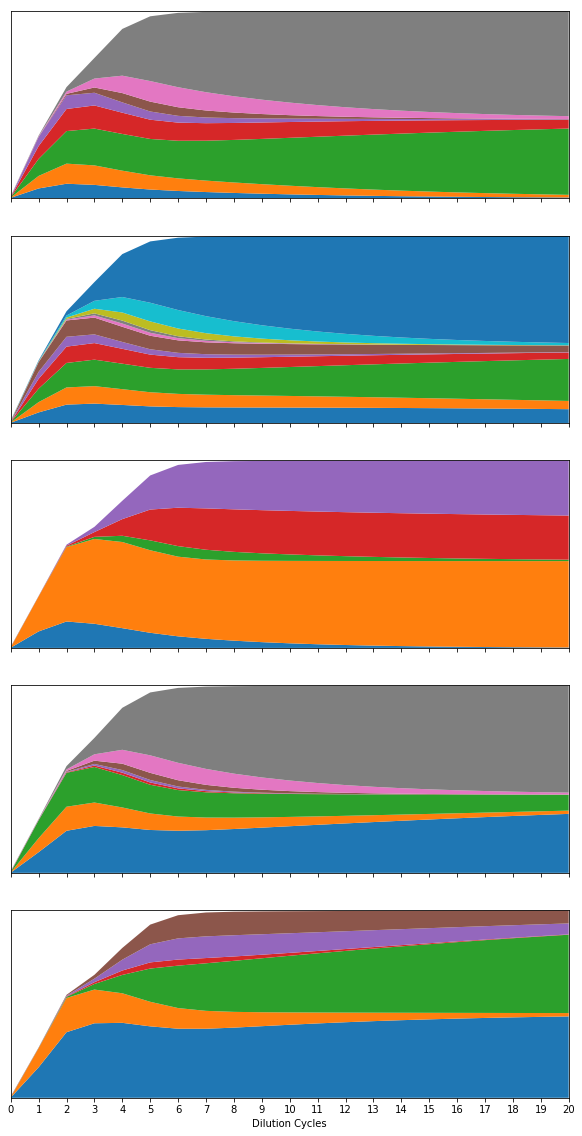

In [61]:
from community_simulator.visualization import PlotTraj
import matplotlib.pyplot as plt

f = np.eye(n_wells)*1e-2
N_traj, R_traj = MyPlate.RunExperiment(f,5,20)

PlotTraj(N_traj,figsize=(10,20))
plt.show()

# Continuous Culture

This package was originally designed for doing batch culture, but it also includes options for continuous culture. The resource dynamics are modeled by functions of the form
\begin{align}
\frac{dR_\alpha}{dt} =h_\alpha (R_\alpha) - \sum_j N_j \nu_{j \alpha}^{\mathrm{in}} + \sum_j N_j \nu_{j \alpha}^{\mathrm{out}},
\end{align}
The default setting in MakeResourceDynamics is to not have any continuous replenishment of resources (`replenishment='off'`), since the resources are resupplied at the beginning of every batch. This is equivalent to setting $h_\alpha = 0$ in the above equation. But you can set `replenishment='non-renew'` to model "non-renewable" or "biotic" resources with logistic growth that are capable of going extinct:
\begin{align}
h_\alpha^{\mathrm{non-renew}} (R_\alpha) = r_\alpha R_\alpha (R_\alpha^0-R_\alpha)
\end{align}
or `replenishment='renew'` to model "renewable" or "abiotic" resources with a linear functional form, which does not allow resource extinction:
\begin{align}
h_\alpha^{\mathrm{renew}} (R_\alpha) = \tau_\alpha^{-1} (R_\alpha^0-R_\alpha).
\end{align}

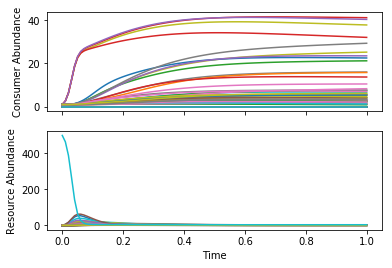

In [34]:
from community_simulator.usertools import MakeMatrices
from community_simulator.usertools import BinaryRandomMatrix
from community_simulator import Community
import numpy as np
from community_simulator.usertools import MakeConsumerDynamics,MakeResourceDynamics,AddLabels
import pandas as pd

species_per_family = 20
resources_per_type = 25
productivity = 500. #abundance of externally supplied resource in absence of consumers
q = 0 #degree of specialization
e = 0.2 #efficiency

pool_params = {'SA': species_per_family*np.ones(4), #Number of species in each family
          'MA': resources_per_type*np.ones(4), #Number of resources of each type
          'Sgen': species_per_family, #Number of generalist species
          'muc': 10, #Mean sum of consumption rates in Gaussian model
          'sigc': .1, #Variance in consumption rate in Gaussian model
          'q': q, #Preference strength 
          'c0':0.01, #Background consumption rate in binary model
          'c1':1., #Maximum consumption rate in binary model
          'fs':0.25, #Fraction of secretion flux with same resource type
          'fw':0.25, #Fraction of secretion flux to 'waste' resource
          'D_diversity':0.2 #Variability in secretion fluxes among resources (must be less than 1)
         }
c, D = MakeMatrices(metaparams = pool_params, kind = 'Binary')

#Create initial conditions (sub-sampling from regional species pool)
S_tot = len(c)
S_well = 50
n_wells = 5
M = len(D)
p = S_well*1./S_tot
N0 = BinaryRandomMatrix(S_tot,n_wells,p)
R0 = np.zeros((M,n_wells))
R0[-1,:] = productivity
N0,R0 = AddLabels(N0,R0,c)
init_state = [N0,R0]

#Construct dynamics
assumptions = {'regulation':'independent','replenishment':'renew','response':'type I'}
def dNdt(N,R,params):
    return MakeConsumerDynamics(**assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(**assumptions)(N,R,params)
dynamics = [dNdt,dRdt]

#Create parameter set
params={'c':c,
        'm':np.ones(S_tot)+0.1*np.random.randn(S_tot),
        'w':np.ones(M),
        'D':D,
        'g':np.ones(S_tot),
        'e':e,
        'R0':R0.values[:,0],
        'r':1.,
        'tau':1
       }

MyPlate = Community(init_state,dynamics,params)

t, Ntraj, Rtraj = MyPlate.TestWell(T=1)

Now let's run for a long time, periodically removing the species that are going extinct, to avoid numerical instabilities (using the multinomial sampling built in to RunExperiment).

In [35]:
Ntraj,Rtraj = MyPlate.RunExperiment(np.eye(n_wells),1,5,refresh_resource=False,scale=1e6)

In [36]:
Ntraj,Rtraj = MyPlate.RunExperiment(np.eye(n_wells),50,10,refresh_resource=False,scale=1e6)

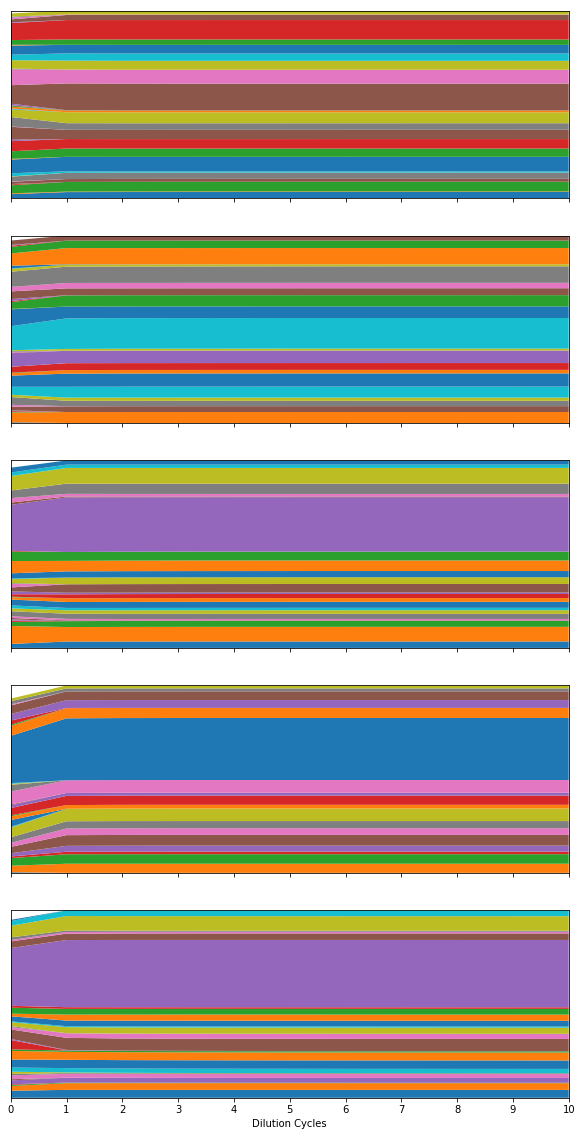

In [37]:
from community_simulator.visualization import PlotTraj
import matplotlib.pyplot as plt
%matplotlib inline

PlotTraj(Ntraj)
plt.show()

We get about 20 species surviving in each well:

In [38]:
(MyPlate.N>0).sum()

W0    24
W1    22
W2    24
W3    20
W4    27
dtype: int64

We can use the Pandas "groupby" feature to sort species by family. The total populations of each family should be fairly even, since family labels ar totally neutral in this simulation (q=0).

In [39]:
MyPlate.N.groupby(level=0).sum().mean(axis=1)

F0      60.923409
F1      68.014688
F2      58.196461
F3     166.345416
GEN    112.986146
dtype: float64

We can also generate heat maps, like the ones commonly used to present microbiome data.

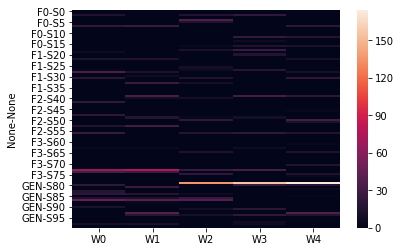

In [40]:
sns.heatmap(MyPlate.N)
plt.show()

# Diauxic Shifts

Setting 'regulation' equal to 'energy' or 'mass' will make each microbe specialize in the most abundant available energy source, weighted either in terms of potential energy flux or potential mass flux. This gives rise to diauxic shifts, where the microbes consume resources sequentially.

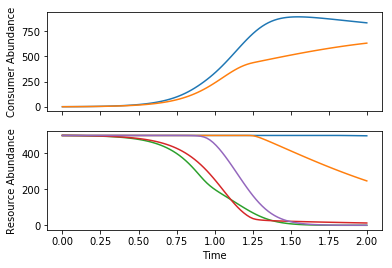

In [74]:
from community_simulator.usertools import MakeMatrices
from community_simulator.usertools import BinaryRandomMatrix
from community_simulator import Community
import numpy as np
from community_simulator.usertools import MakeConsumerDynamics,MakeResourceDynamics,AddLabels
import pandas as pd

M = 5
productivity = 500. #abundance of externally supplied resource in absence of consumers
e = 1.

pool_params = {'SA': np.asarray([2]), #Number of species in each family
          'MA': np.asarray([M]), #Number of resources of each type
          'Sgen': 0, #Number of generalist species
          'muc': 5, #Mean sum of consumption rates in Gaussian model
          'sigc': 3, #Variance in consumption rate in Gaussian model
          'q': 0, #Preference strength 
          'c0':0.01, #Background consumption rate in binary model
          'c1':1., #Maximum consumption rate in binary model
          'fs':0.25, #Fraction of secretion flux with same resource type
          'fw':0.25, #Fraction of secretion flux to 'waste' resource
          'D_diversity':0.2 #Variability in secretion fluxes among resources (must be less than 1)
         }
c, D = MakeMatrices(metaparams = pool_params, kind = 'Gamma')

#Create initial conditions (sub-sampling from regional species pool)
N0 = np.asarray([1,1])
R0 = np.ones(M)*productivity
#N0,R0 = AddLabels(N0,R0,c)
init_state = [N0,R0]

#Construct dynamics
assumptions = {'regulation':'energy','replenishment':'off','response':'type II'}
def dNdt(N,R,params):
    return MakeConsumerDynamics(**assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(**assumptions)(N,R,params)
dynamics = [dNdt,dRdt]

#Create parameter set
params={'c':c,
        'm':0.2,
        'w':1,
        'D':D,
        'g':1,
        'e':e,
        'R0':R0,
        'r':1.,
        'tau':1,
        'nreg':10,
        'K':10
       }

MyPlate = Community(init_state,dynamics,params)

t, Ntraj, Rtraj = MyPlate.TestWell(T=2)